In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('MNRAS')
from scipy import linalg
from scipy.interpolate import interp1d

In [2]:
## make the fake data
iz = 2 # 0, 1, 2
zid = iz+3
data_loc = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_data/base_c000_ph000/'
data_loc += f'z0p{zid}00/model_hod000000/obs_q180_desy1/'
rp_rad = np.loadtxt(f'/projects/hywu/cluster_sims/cluster_finding/data/emulator_train/all/train/z0p{zid}00/rp_rad.dat')

#### lesing data ####
DS_data = []
for ilam in range(4):
    rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_lam_bin_{ilam}.dat', unpack=True)
    DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
    DS_data.extend(np.exp(DS_interp(np.log(rp_rad))))
DS_data = np.array(DS_data)

#### lensing cov ####
cov_loc = '/users/hywu/work/cluster-lensing-cov-public/examples/abacus_summit_analytic/'
lam = [20, 30, 45, 60, 1000]
z = [0.2, 0.35, 0.5, 0.65]

for ilam in range(4):    
    rp_cov = np.loadtxt(cov_loc + f'rp_phys_noh_{z[iz]}_{z[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
    print('check radius difference', '%.2g'%max(abs(rp_cov[4:]/rp_rad - 1)))
    data = np.loadtxt(cov_loc + f'DeltaSigma_cov_combined_phys_noh_{z[iz]}_{z[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
    data = data[4:,4:]
    if ilam == 0:
        cov_DS = data * 1.
    else:
        cov_DS = linalg.block_diag(cov_DS, data)
print('np.shape(cov_DS)', np.shape(cov_DS))
cov_DS_inv = linalg.inv(cov_DS)


#### counts data ####
x, x, NC_data = np.loadtxt(data_loc+'abundance.dat',unpack=True)

#### counts cov ####
cov_NC = []
for ilam in range(4):    
    counts, sv, bias, lnM_mean = np.loadtxt(cov_loc + f'counts_{z[iz]}_{z[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
    cov_NC.append(counts + sv)
cov_NC = np.diag(cov_NC)
cov_NC_inv = linalg.inv(cov_NC)


#### combine counts and lensing 
data_vec = np.append(NC_data, DS_data)
from scipy.linalg import block_diag
cov = block_diag(cov_NC, cov_DS)
cov_inv = block_diag(cov_NC_inv, cov_DS_inv)

print('np.shape(cov_inv)', np.shape(cov_inv))

np.savetxt(f'data_vector_abacus_summit/data_vector_z0p{zid}00.dat', data_vec)
np.savetxt(f'data_vector_abacus_summit/cov_inv_z0p{zid}00.dat', cov_inv)
np.savetxt(f'data_vector_abacus_summit/cov_z0p{zid}00.dat', cov)

check radius difference 0.04
check radius difference 0.04
check radius difference 0.04
check radius difference 0.04
np.shape(cov_DS) (44, 44)
np.shape(cov_inv) (48, 48)


In [3]:
# # check radius!
# rp_rad = np.loadtxt(f'/projects/hywu/cluster_sims/cluster_finding/data/emulator_train/train/rp_rad.dat')

# rp_cov = np.loadtxt(cov_loc + 'rp_hiMpc_0.35_0.5_60_1000.dat')[:,2] * a / h
# print((rp_cov[4:] - rp_rad)/rp_rad) #okay!

frac noise: DS [0.19643971 0.1815903  0.1767294  0.1806956  0.20994312 0.25244375
 0.26652735 0.24850133 0.22049265 0.19879812 0.19329927]
frac noise: DS [0.21397275 0.18962402 0.17736137 0.17294442 0.18686002 0.21921458
 0.2452976  0.24789354 0.2343038  0.2191822  0.21604403]
frac noise: DS [0.29381883 0.25018631 0.22560215 0.21238729 0.21843531 0.250707
 0.28952234 0.31073666 0.31209141 0.3053921  0.30706267]
frac noise: DS [0.2608445  0.21138734 0.18219893 0.16492426 0.16132375 0.17888141
 0.21256912 0.24359806 0.25923325 0.26478376 0.27693087]
frac noise: NC [0.0175447  0.03118481 0.06686312 0.11222373]


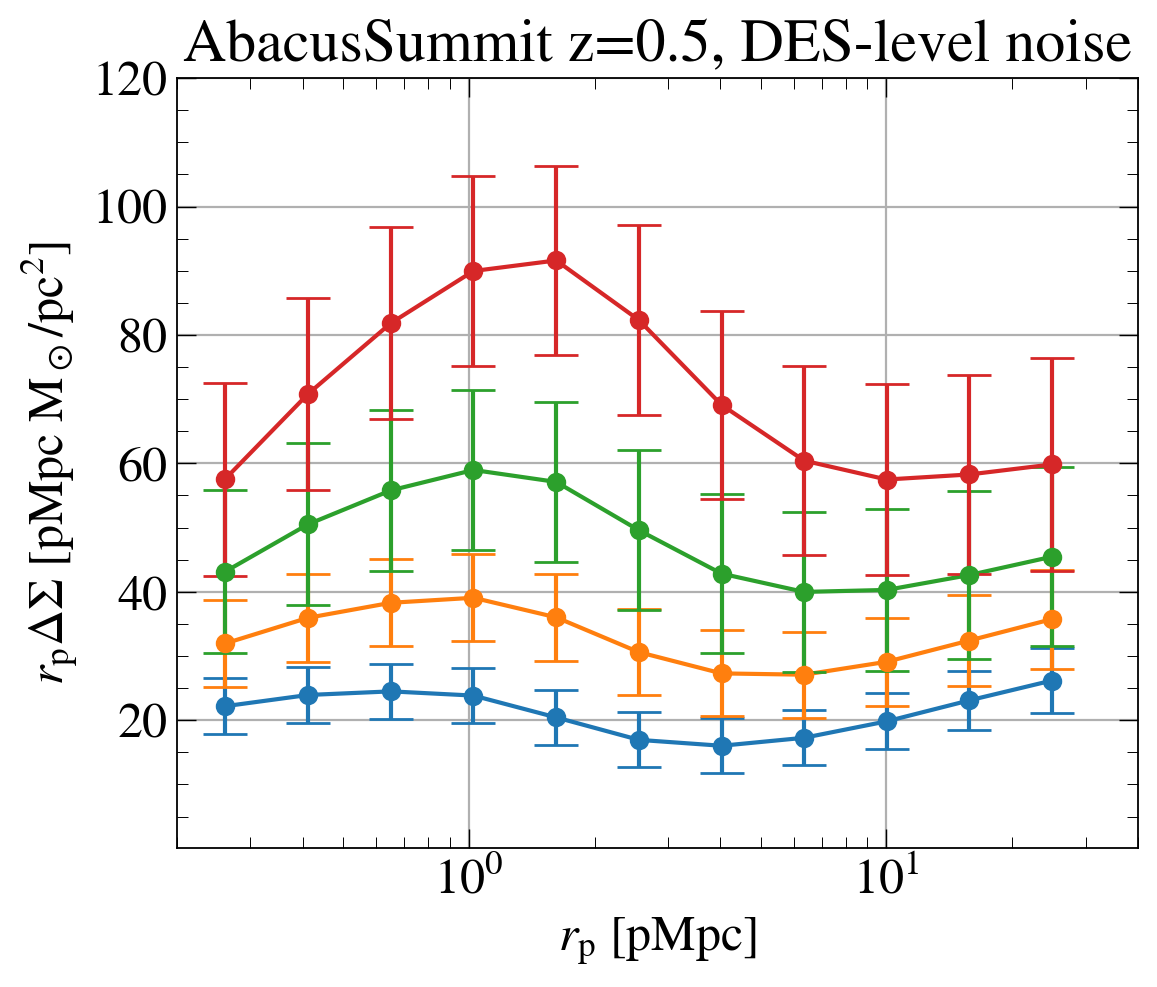

In [4]:
# plot the fake data and error bars
cov_loc = '/users/hywu/work/cluster-lensing-cov-public/examples/abacus_summit_analytic/'
for ilam in range(4):
    rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_lam_bin_{ilam}.dat', unpack=True)
    DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
    DS_data = np.exp(DS_interp(np.log(rp_rad)))

    cov = np.loadtxt(cov_loc + f'DeltaSigma_cov_combined_phys_noh_{z[iz]}_{z[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
    sig = np.sqrt(np.diag(cov))[4:]
    line = plt.plot(rp_rad, rp_rad*DS_data)
    co = line[0].get_c()
    plt.errorbar(rp_rad, rp_rad*DS_data, rp_rad*sig, 
                 label='data', c=co, marker='o', mec=co, ls='', capsize=8)#, np.diag(cov))
    plt.xscale('log')
    print('frac noise: DS', sig/DS_data)

plt.xlim(0.2, 40)
plt.ylim(0.10, 120)
plt.title(f'AbacusSummit z=0.{zid}, DES-level noise')

plt.xlabel(r'$r_{\rm p}~[{\rm pMpc}]$')
plt.ylabel(r'$r_{\rm p} \Delta\Sigma~[{\rm pMpc ~M_\odot/pc^2} ]$')
sig_NC = np.sqrt(np.diag(cov_NC))
print('frac noise: NC',sig_NC/NC_data)
plt.savefig(f'../../plots/emulator/abacus_summit_fid_lensing_z0.{zid}.pdf')